# Fit FTS etalon ET2A etalon lines and save outputs for CAP401
In this notebook we fit the RAL FTS ET2A etalon lines and save the outputs, such that they can be used in the context of CAP401.  
  
Notebook creation date: 14th of March 2018  
Author: Ioannis Argyriou (Institute of Astronomy, KUL)  
Email: ioannis.argyriou@kuleuven.be

## > Import modules

In [1]:
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

## > Get data

In [2]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
MRSWaveCalDir = workDir+'MRSWaveCal/'

# Get data
#> Etalon FTS data
wvnrs2A,etalon2A = mrsobs.RAL_FTS_ET_observations(MRSWaveCalDir,etalon='ET2A')

## > Transform data

In [12]:
# select data wavenumber range from wavelength range
lamblower,lambupper = 8.93,18.54
wvnrlower,wvnrupper = 10000./lambupper,10000./lamblower
sel = (wvnrs2A>=wvnrlower) & (wvnrs2A<=wvnrupper)
wvnrs2A_FTS_data,etalon2A_FTS_data = wvnrs2A[sel],etalon2A[sel]

In [13]:
# find etalon line peak positions
FTSetalon2A_peaks = funcs.find_peaks(etalon2A_FTS_data,thres=0.,min_dist=250)
FTSetalon2A_peaks = np.unique(FTSetalon2A_peaks)

<IPython.core.display.Javascript object>


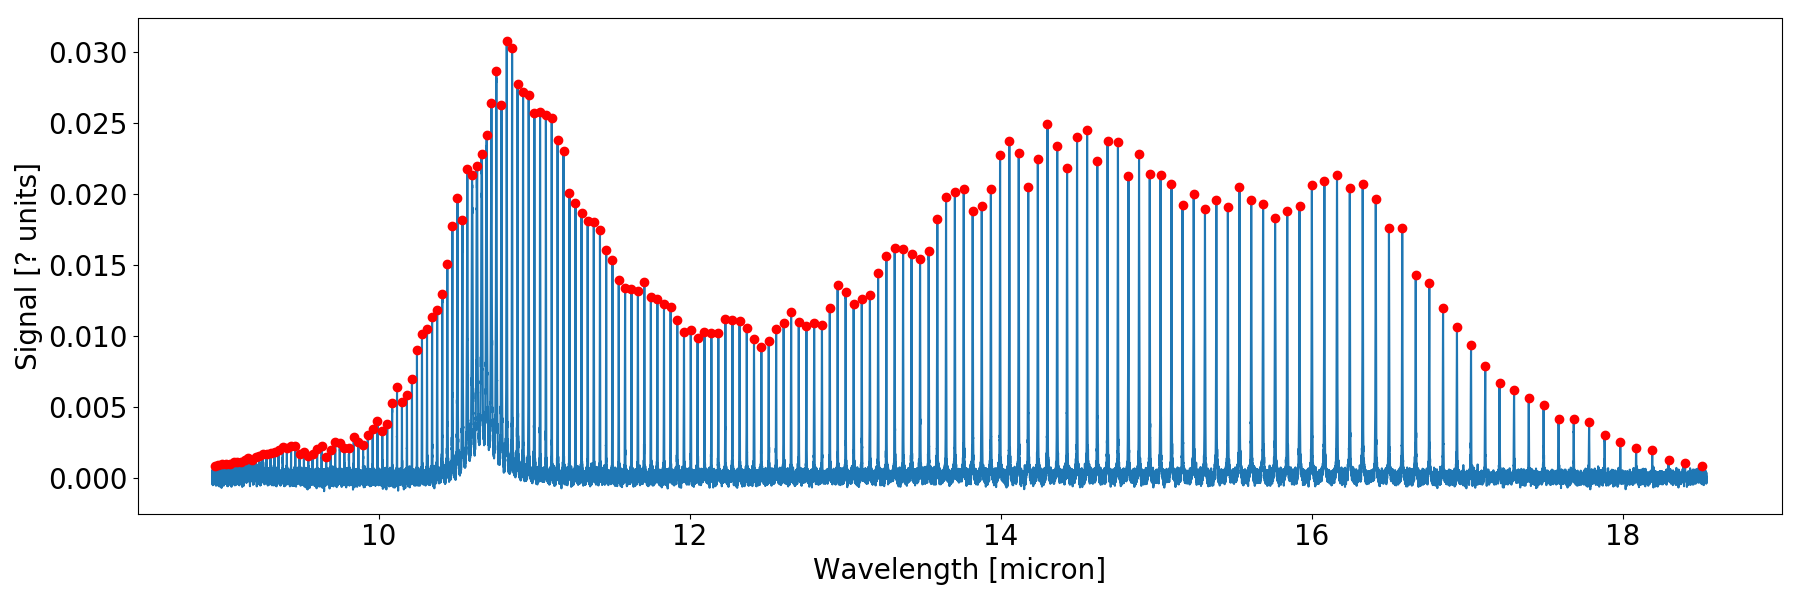

In [14]:
# fitting of etalon lines is done in wavelength space
lambdas2A_FTS_data,etalon2A_FTS_data_wvl = np.flipud(10000./wvnrs2A[sel]),np.flipud(etalon2A[sel])
FTSetalon2A_peaks_wvl = np.flipud((len(lambdas2A_FTS_data)-1) - FTSetalon2A_peaks)

plt.figure(figsize=(18,6))
plt.plot(lambdas2A_FTS_data,etalon2A_FTS_data_wvl)
plt.plot(lambdas2A_FTS_data[FTSetalon2A_peaks_wvl],etalon2A_FTS_data_wvl[FTSetalon2A_peaks_wvl],'ro')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [? units]')
plt.tight_layout()

<IPython.core.display.Javascript object>


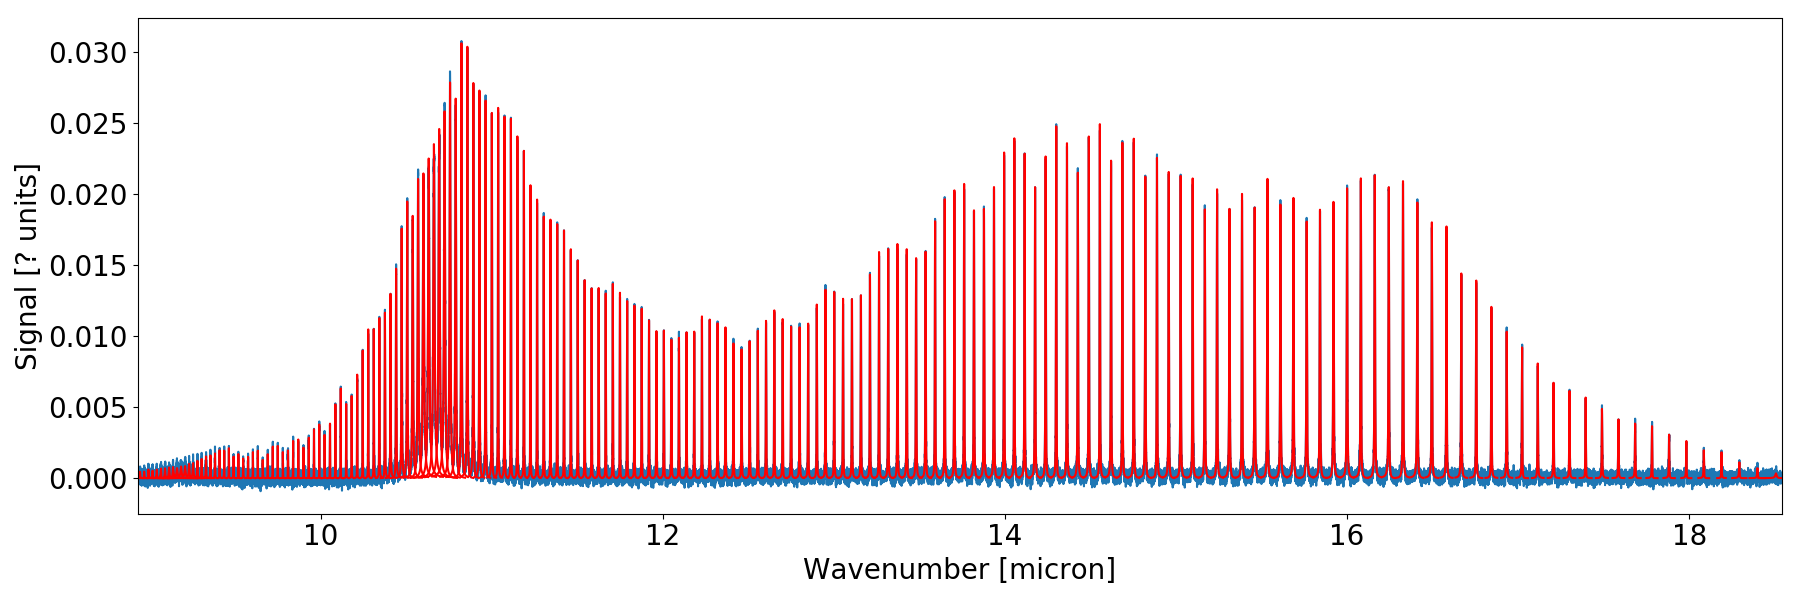

In [15]:
#-- Fit Etalon_2A lines in FTS data
etalon2A_fitparams,etalon2A_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdas2A_FTS_data,etalon2A_FTS_data_wvl,FTSetalon2A_peaks_wvl,fit_func='skewed_voight',sigma0=0.001,f0=0.5,a0=0.1)

# flag id
flag = np.zeros(len(fitting_flag))
for line in range(len(fitting_flag)):
    if fitting_flag[line] == 'gauss1d':              flag[line] = 0
    elif fitting_flag[line] == 'skewnorm_func':      flag[line] = 1
    elif fitting_flag[line] == 'lorentzian_profile': flag[line] = 2
    elif fitting_flag[line] == 'voight_profile':     flag[line] = 3
    elif fitting_flag[line] == 'skewed_voight':      flag[line] = 4

# etalon line single parameters
amplitude  = funcs.get_amplitude(etalon2A_fitparams,fitting_flag)
linecenter = funcs.get_linecenter(etalon2A_fitparams,fitting_flag)
linefwhm   = funcs.get_FWHM(etalon2A_fitparams,fitting_flag)
lineskew   = funcs.get_skewness(etalon2A_fitparams,fitting_flag)

amplitude_error = np.array([np.sqrt(np.diag(etalon2A_fiterrors[i]))[0] for i in range(len(etalon2A_fiterrors))])
linecenter_error = np.array([np.sqrt(np.diag(etalon2A_fiterrors[i]))[1] for i in range(len(etalon2A_fiterrors))])
sigma0_error = np.array([np.sqrt(np.diag(etalon2A_fiterrors[i]))[2] for i in range(len(etalon2A_fiterrors))])

plt.close('all')
plt.figure(figsize=(18,6))
plt.plot(lambdas2A_FTS_data,etalon2A_FTS_data_wvl)
funcs.plot_etalon_fit(etalon2A_fitparams,fitting_flag)
plt.xlim(lamblower,lambupper)
plt.xlabel('Wavenumber [micron]')
plt.ylabel('Signal [? units]')
plt.tight_layout()

In [17]:
# Save results
# Outline provided by Alvaro: Lam_cent - Err_Lam_cent - FWHM - Err_FWHM - Res - Err_Res - Height - Err_height - Lam_ini - Lam_fin - Norm.chi2 - Cont_slope - Cont_constant - Maximos - Dif_cen_max
hdu0 = fits.PrimaryHDU()
hdu0.header["INSTRUME"]="RAL_FTS"
hdu0.header["ETALON"]="2A"
hdu0.header["FILENAME"]= "RAL_FTS_ET2A_FITPARAMS_07.01.00.fits"
hdu0.header["DATE"]="2018-03-14"
hdu0.header["VERSION"] ="07.01.00"
hdu0.header["USEAFTER"] =""
hdu0.header["AUTHOR"]  ="Ioannis Argyriou"
hdu0.header["ORIGIN"]  = "MIRI European Consortium"
hdu0.header.add_history("DATA USED: RAL FTS MIRI_b_K1av_etalon2A_80K.txt data")
cols = []
cols.append(fits.Column(name="FLAG",format='I', array=flag))
cols.append(fits.Column(name="LAMCEN",format='D', array=linecenter,unit='micron'))
cols.append(fits.Column(name="eLAMCEN",format='D', array=linecenter_error,unit='micron'))
cols.append(fits.Column(name="HEIGHT",format='D', array=amplitude,unit='[det sign]'))
cols.append(fits.Column(name="eHEIGHT",format='D', array=amplitude_error,unit='[det sign]'))
cols.append(fits.Column(name="SIGMA0",format='D', array=np.array([etalon2A_fitparams[i][2] for i in range(len(etalon2A_fitparams))]),unit='micron'))
cols.append(fits.Column(name="eSIGMA0",format='D', array=sigma0_error,unit='micron'))
cols.append(fits.Column(name="FRAC",format='D', array=np.array([etalon2A_fitparams[i][3] for i in range(len(etalon2A_fitparams))]),unit='[-]'))
cols.append(fits.Column(name="SKEW",format='D', array=lineskew,unit='[-]'))
cols.append(fits.Column(name="FWHM",format='D', array=linefwhm,unit='micron'))
cols.append(fits.Column(name="RES",format='D', array=linecenter/linefwhm,unit='[-]'))
cols.append(fits.Column(name="LAM_INI",format='D', array=range_ini,unit='micron'))
cols.append(fits.Column(name="LAM_FIN",format='D', array=range_fin,unit='micron'))
cols.append(fits.Column(name="MAXIMUM",format='D', array=etalon2A_FTS_data[FTSetalon2A_peaks_wvl],unit='[det sign]'))
cols.append(fits.Column(name="LAMDIFF",format='D', array=lambdas2A_FTS_data[FTSetalon2A_peaks_wvl]-linecenter,unit='micron'))
hdu1 = fits.BinTableHDU.from_columns(fits.ColDefs(cols),header=None,name="SCI")
hdu1.header["FLAG"]= "Fitting function"
hdu1.header["LAMCEN"]= "Central wavelength"
hdu1.header["eLAMCEN"]= "Central wavelength error"
hdu1.header["HEIGHT"]= "Etalon line peak signal"
hdu1.header["eHEIGHT"]= "Etalon line peak signal error"
hdu1.header["SIGMA0"]= "Etalon line STD"
hdu1.header["eSIGMA0"]= "Etalon line STD error"
hdu1.header["FRAC"]= "Lorentzian-to-Gauss fraction"
hdu1.header["eFRAC"]= "Lorentzian-to-Gauss fraction error"
hdu1.header["SKEW"]= "Skewness parameter"
hdu1.header["eSKEW"]= "Skewness parameter error"
hdu1.header["FWHM"]= "Full-width at half maximum"
hdu1.header["eFWHM"]= "Full-width at half maximum error"
hdu1.header["RES"]= "Spectral resolution LAMCEN/FWHM"
hdu1.header["eRES"]= "Spectral resolution error"
hdu1.header["LAM_INI"]= "Fit range initial wavelength"
hdu1.header["LAM_FIN"]= "Fit range final wavelength"
hdu1.header["MAXIMUM"]= "Un-fitted peak signal"
hdu1.header["LAMDIFF"]= "Un-fitted vs fitted line wavelength"
hdu1.header.add_history("Flag list is: (0) Gaussian, (1) Skewed Gaussian, (2) Lorentzian, (3) Voight, (4) Skewed Voight")
hdu1.header.add_history("Note: Continuum is fixed at zero.")
hdulist = fits.HDUList([hdu0,hdu1])
hdulist.writeto("RAL_FTS_ET2A_FITPARAMS_07.01.00.fits",overwrite=True)